In [ ]:
# Mount this script to my drive
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/2022_趨勢_機器學習比賽/OBJ_Train_Datasets/')

# **Read packages**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
import random

# Define the function for reading the box information

In [3]:
# Read the dataset and return the image as a 3D array and a dictionary contains 
# all important information listed in the annotation files.
# Be aware that 
# (1) the color order of the img array is BGR if you use cv2.imread.
# (2) the dimensions of the image are ordered in (y,x,color).

def Read(img_num,read_img=True):
  img_file=f'./Train_Images/{img_num}.jpg'
  ann_file=f'./Train_Annotations/{img_num}.xml'
  tree = ET.parse(ann_file)
  root = tree.getroot()
  inf_dict={}
  count=0

  for obj in root.findall('object'):
    xmin=int(obj.find('bndbox').find('xmin').text)
    ymin=int(obj.find('bndbox').find('ymin').text)
    xmax=int(obj.find('bndbox').find('xmax').text)
    ymax=int(obj.find('bndbox').find('ymax').text)
    inf_dict[count]=[(xmin,ymin),(xmax,ymax)]
    count+=1

  inf_dict['STAS_num']=count
  inf_dict['xsize']=root.find('size').find('width').text
  inf_dict['ysize']=root.find('size').find('height').text
  inf_dict['zsize']=root.find('size').find('depth').text

  if read_img:
    img=cv2.imread(img_file)
    return img, inf_dict
  else:
    return inf_dict

# Some statistics

In [ ]:
# Identify the distribution of the number of STAS in each training image.
img_num_list=[f'{i:08}' for i in range(1053)] # We have 1053 training images

stas_num_list=[]
area_list=[]
shape_list=[]
img_size=1716*942

# Number of STAS in each image, size and shape distibution
for img_num in img_num_list:
  print(f'Dealing with image {img_num} now....')
  inf = Read(img_num,read_img=False)
  stas_num_list.append(inf['STAS_num'])
  for obj_num in range(inf['STAS_num']):
    x_ind1,x_ind2=inf[obj_num][0][0],inf[obj_num][1][0]
    y_ind1,y_ind2=inf[obj_num][0][1],inf[obj_num][1][1]
    xlen,ylen=x_ind2-x_ind1,y_ind2-y_ind1
    area=xlen*ylen/img_size
    shape=xlen/ylen
    area_list.append(area)
    shape_list.append(shape)



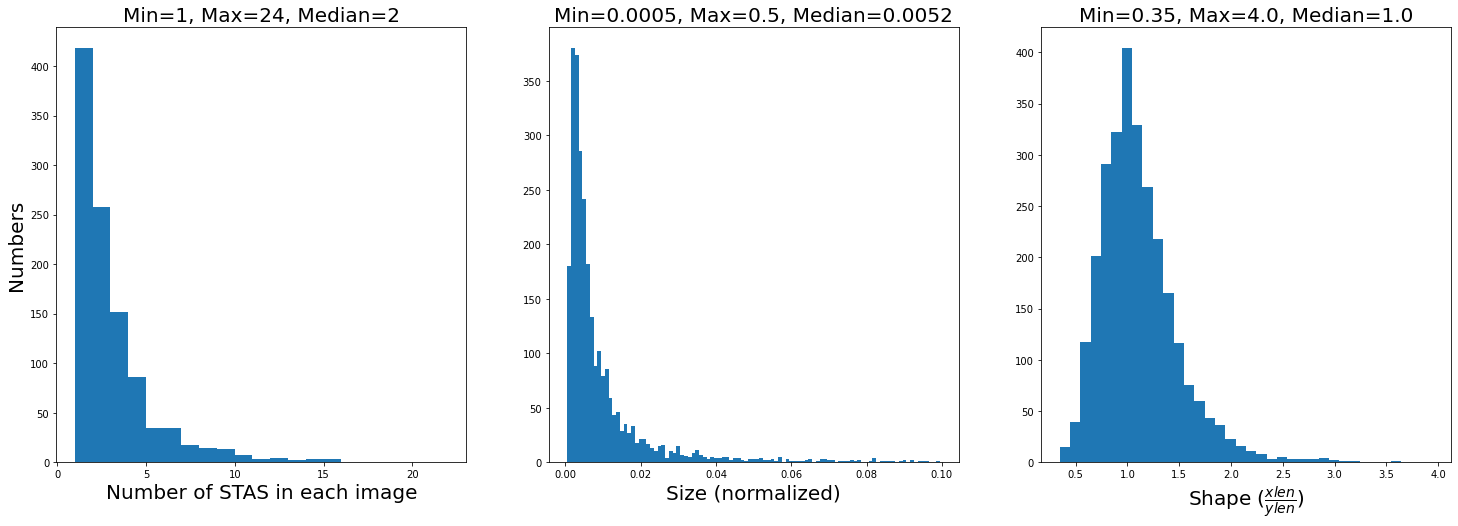

In [ ]:
# Plot the result and save
# the range 0~0.1 covers >98% values of sizes in the list.
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.hist(stas_num_list,bins=range(min(stas_num_list),max(stas_num_list)-1,1))
plt.xlabel('Number of STAS in each image',size=20)
plt.ylabel('Numbers',size=20)
plt.title(f'Min={min(stas_num_list)}, Max={max(stas_num_list)}, Median={int(np.median(stas_num_list))}',size=20);
plt.subplot(132)
plt.hist(area_list,bins=np.arange(min(area_list),0.1,0.001)); 
plt.xlabel('Size (normalized)',size=20)
plt.title(f'Min={np.around(min(area_list),4)}, Max={np.around(max(area_list),1)}, Median={np.around(np.median(area_list),4)}',size=20);
plt.subplot(133)
plt.hist(shape_list,bins=np.arange(min(shape_list),max(shape_list),0.1)); 
plt.xlabel(r'Shape ($\frac{xlen}{ylen}$)',size=20);
plt.title(f'Min={np.around(min(shape_list),2)}, Max={np.around(max(shape_list),1)}, Median={np.around(np.median(shape_list),1)}',size=20);
# plt.savefig('Statistics/STAS_basic_hist.jpg');
# plt.close()

# The distribution of IOU in our training set
This information could help us to decide the nms IOU threshold.

In [16]:
# Defin the function that 
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'xmin', 'xmax', 'ymin', 'ymax'}
        The (xmin, ymin) position is at the top left corner,
        the (xmax, ymax) position is at the bottom right corner
    bb2 : dict
        Keys: {'xmin', 'xmax', 'ymin', 'ymax'}
        The (xmin, ymin) position is at the top left corner,
        the (xmax, ymax) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['xmin'] < bb1['xmax']
    assert bb1['ymin'] < bb1['ymax']
    assert bb2['xmin'] < bb2['xmax']
    assert bb2['ymin'] < bb2['ymax']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['xmin'], bb2['xmin'])
    y_top = max(bb1['ymin'], bb2['ymin'])
    x_right = min(bb1['xmax'], bb2['xmax'])
    y_bottom = min(bb1['ymax'], bb2['ymax'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left+1) * (y_bottom - y_top+1)

    # compute the area of both AABBs
    bb1_area = (bb1['xmax'] - bb1['xmin']+1) * (bb1['ymax'] - bb1['ymin']+1)
    bb2_area = (bb2['xmax'] - bb2['xmin']+1) * (bb2['ymax'] - bb2['ymin']+1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou


In [ ]:
# Calculate the IOU distribution within our training set
img_num_list=[f'{i:08}' for i in range(1053)] # We have 1053 training images

IOU_list=[]

# Number of STAS in each image, size and shape distibution
for img_num in img_num_list:
  print(f'Dealing with image {img_num} now....')
  inf = Read(img_num,read_img=False)
  for obj_num1 in range(inf['STAS_num']):
    x_min1,x_max1=inf[obj_num1][0][0],inf[obj_num1][1][0]
    y_min1,y_max1=inf[obj_num1][0][1],inf[obj_num1][1][1]
    box_dict1={'xmin':x_min1,'xmax':x_max1,'ymin':y_min1,'ymax':y_max1}
    for obj_num2 in range(obj_num1):
      x_min2,x_max2=inf[obj_num2][0][0],inf[obj_num2][1][0]
      y_min2,y_max2=inf[obj_num2][0][1],inf[obj_num2][1][1]
      box_dict2={'xmin':x_min2,'xmax':x_max2,'ymin':y_min2,'ymax':y_max2}
      iou = get_iou(box_dict1, box_dict2);
      IOU_list.append(iou)

5306
0.0061075660893345485
0.07070989379541644


Text(0.5, 1.0, 'Training set')

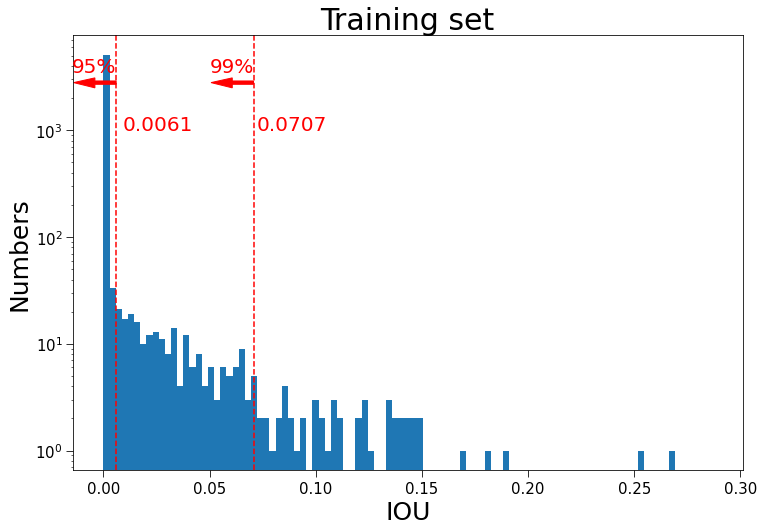

In [159]:
# Plot the result
IOU_list.sort()
IOU_list_len = len(IOU_list)
accumulation_pos = [IOU_list[int(IOU_list_len*0.95)],IOU_list[int(IOU_list_len*0.99)]]  # ninety_fifth, ninety_ninth
plt.figure(figsize=(12,8))
plt.hist(IOU_list,bins = np.linspace(0,max(IOU_list)+0.02,100));
for i in accumulation_pos:
  print(i)
  plt.axvline(x=i,color='r',linestyle='--')
plt.yscale('log', nonposy='clip')
plt.xlabel('IOU',size=25)
plt.ylabel('Numbers',size=25)
plt.tick_params(axis='both',labelsize=15,length=7)

plt.text(-0.015,3500,'95%',color='r',size = 20)
plt.text(0.050,3500,'99%',color='r',size = 20)
plt.text(0.009,1000,'0.0061',color='r',size = 20)
plt.text(0.072,1000,'0.0707',color='r',size = 20)
plt.arrow(0.006, 2800, -0.01, 0,color = 'r',width=200,head_length=0.01) 
plt.arrow(0.0707, 2800, -0.01, 0,color = 'r',width=200,head_length=0.01) 
plt.title('Training set',size=30)